## Data

In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data
Heloc = pd.read_csv("HelocData.csv")
# Select feature 1, 5, 16, 17, 20 for the model
Heloc = Heloc[["RiskFlag", "x1", "x5", "x16", "x17", "x20"]]
Heloc = pd.get_dummies(Heloc, columns=["RiskFlag"], drop_first=True)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
np.random.seed(3035480699)
df_train, df_test = train_test_split(Heloc, test_size = 0.2)

# Replace missing features with feature means
from sklearn.impute import SimpleImputer
def df_imputer(df):
    df_cp = df.copy()
    df_cp.replace([-7, -8, -9], np.nan, inplace=True)
    fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
    fill_NaN = fill_NaN.fit(df_cp.iloc[:,0:5])
    df_cp.iloc[:,0:5] = fill_NaN.transform(df_cp.iloc[:,0:5])
    return df_cp

df_train_imp = df_imputer(df_train)
df_test_imp = df_imputer(df_test)

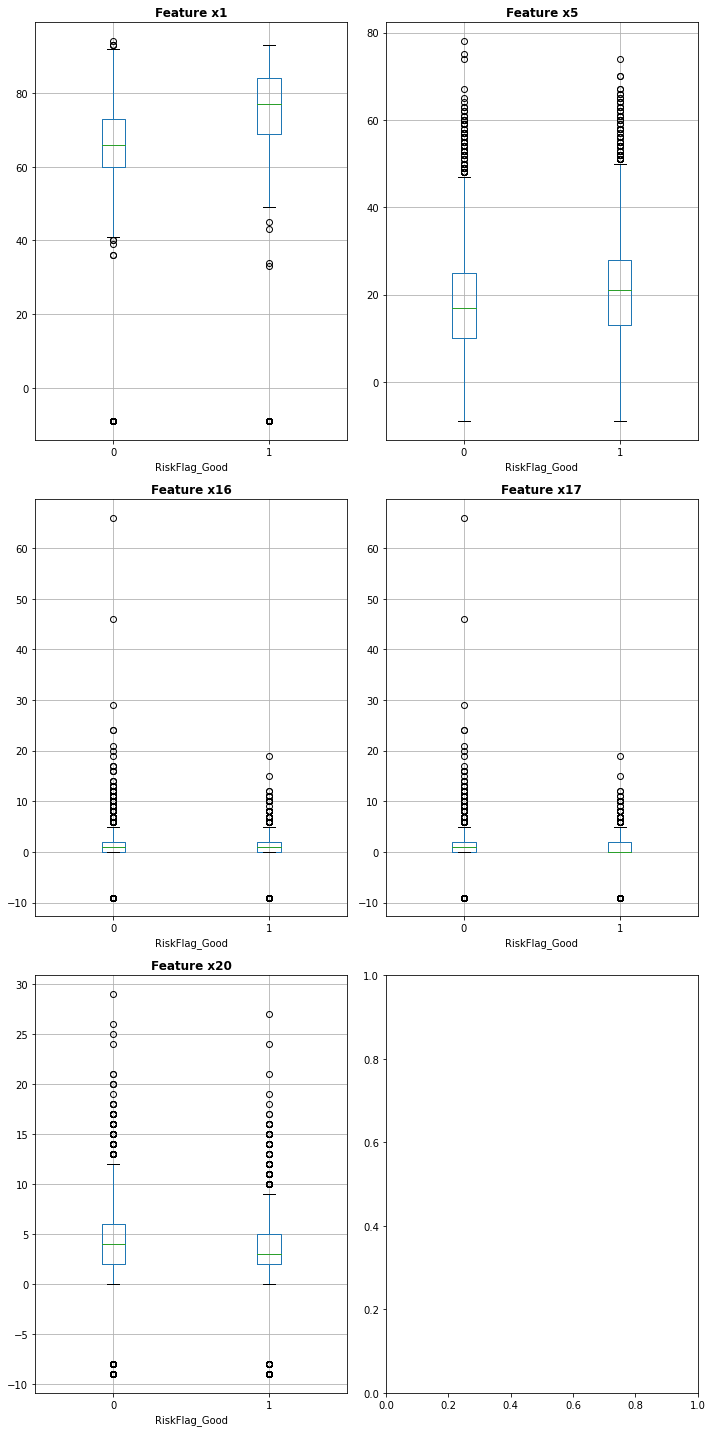

In [ ]:
import math
n = 2 #number of plot per row
features = df_train_imp.iloc[:,0:5].columns
fig, axes = plt.subplots(math.ceil(len(features)/n),n, figsize = (10,20))
for i, feature in enumerate(features):
    plt.subplot(axes[i//n,i%n])
    df_train.boxplot(column = feature, by = "RiskFlag_Good", ax = axes[i//n,i%n])
    plt.title("Feature " + feature, fontsize = 12, fontweight = "bold")
fig.suptitle('')
fig.tight_layout()
plt.show()

## Model (1): GAM with Binning

In [ ]:
# Use IV Binning
import scorecardpy as sc
from sklearn.preprocessing import OrdinalEncoder
def binning(df):
    df_bin = df.copy()
    bins = sc.woebin(df_train, y = "RiskFlag_Good", 
                 x = ["x1", "x5", "x16", "x17", "x20"], method='tree')
    x1_breaks = np.insert(bins["x1"]["breaks"].values.astype(np.float), 0, -np.inf)
    df_bin["x1"] = pd.cut(df_bin["x1"], bins=x1_breaks, right=True)
    x5_breaks = np.insert(bins["x5"]["breaks"].values.astype(np.float), 0, -np.inf)
    df_bin["x5"] = pd.cut(df_bin["x5"], bins=x5_breaks, right=True)
    x16_breaks = np.insert(bins["x16"]["breaks"].values.astype(np.float), 0, -np.inf)
    df_bin["x16"] = pd.cut(df_bin["x16"], bins=x16_breaks, right=True)
    x17_breaks = np.insert(bins["x17"]["breaks"].values.astype(np.float), 0, -np.inf)
    df_bin["x17"] = pd.cut(df_bin["x17"], bins=x17_breaks, right=True)
    x20_breaks = np.insert(bins["x20"]["breaks"].values.astype(np.float), 0, -np.inf)
    df_bin["x20"] = pd.cut(df_bin["x20"], bins=x20_breaks, right=True)
    
    x_bin = df_bin[["x1", "x5", "x16", "x17", "x20"]]
    y_bin = df_bin[["RiskFlag_Good"]]
    
    # Ordinal encoding of binning features
    enc = OrdinalEncoder()
    x_bin = enc.fit_transform(x_bin)
    
    return x_bin, y_bin

x_train_bin, y_train_bin = binning(df_train)


[INFO] creating woe binning ...


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


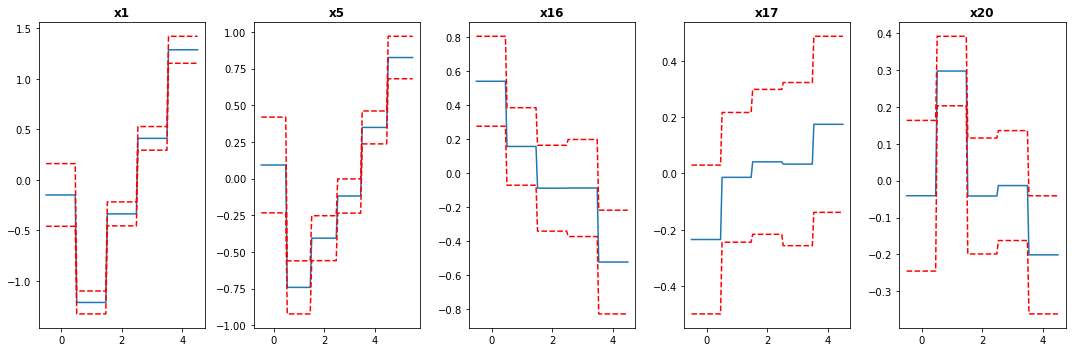

In [ ]:
# GAM with binning
from pygam import LogisticGAM,f,l,s

gam_bin = LogisticGAM(f(0)+f(1)+f(2)+f(3)+f(4))
gam_bin.gridsearch(x_train_bin,y_train_bin)

#Partial dependece plot
fig, axs = plt.subplots(1,5,figsize=(15,5))
names = ["x1", "x5", "x16", "x17", "x20"]
for i, ax in enumerate(axs.flatten()):
    XX = gam_bin.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam_bin.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam_bin.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i],fontsize=12, fontweight="bold")
plt.tight_layout()

## Model (2): GAM with piecewise-linear feature engineering

Piece-wise linear is achieved in LogisticGAM from pygam by the spline term, specifying spline order = 1 and removing the automatic penalty. It is found that the number of splines cannot exceed 13 or else overflow will occur. After evaluating the accuracy on training set, it is found that n_splines = 5 produces the highest accuracy. It is hence used in the model below.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Accuracy of piecewise-linear model on training dataset: 0.7113660810326282


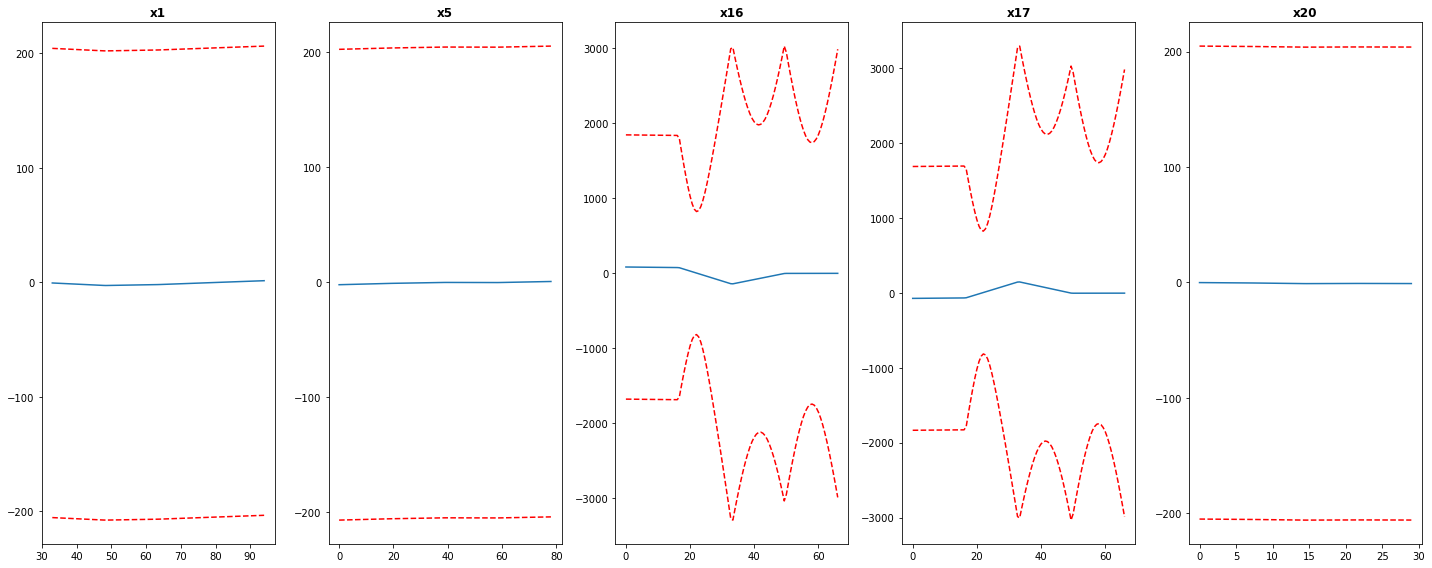

In [ ]:
y_train = df_train_imp[["RiskFlag_Good"]]
x_train = df_train_imp[["x1", "x5", "x16", "x17", "x20"]]
n_splines = 5
gam_pwlin = LogisticGAM(s(0, penalties=None,n_splines=n_splines,spline_order=1)+
                          s(1, penalties=None,n_splines=n_splines,spline_order=1)+
                          s(2, penalties=None,n_splines=n_splines,spline_order=1)+
                          s(3, penalties=None,n_splines=n_splines,spline_order=1)+
                          s(4, penalties=None,n_splines=n_splines,spline_order=1))
gam_pwlin.gridsearch(x_train.to_numpy() ,y_train)

from sklearn.metrics import accuracy_score
yhat_train_pwlin = gam_pwlin.predict(x_train)
print('Accuracy of piecewise-linear model on training dataset:',accuracy_score(y_train,yhat_train_pwlin))

#Partial dependece plot
fig, axs = plt.subplots(1,5,figsize=(20,8))
names = ["x1", "x5", "x16", "x17", "x20"]
for i, ax in enumerate(axs.flatten()):
    XX = gam_pwlin.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam_pwlin.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam_pwlin.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i],fontsize=12, fontweight="bold")
plt.tight_layout()

## Model (3): GAM with penalized B-splines up to degree 3

Partial dependence plots for all five features with spline order = 3 were generated. It is found that higher spline order produces higher accuracy in training dataset.

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Accuracy of penalized B-splines model on training dataset: 0.7098123580733835


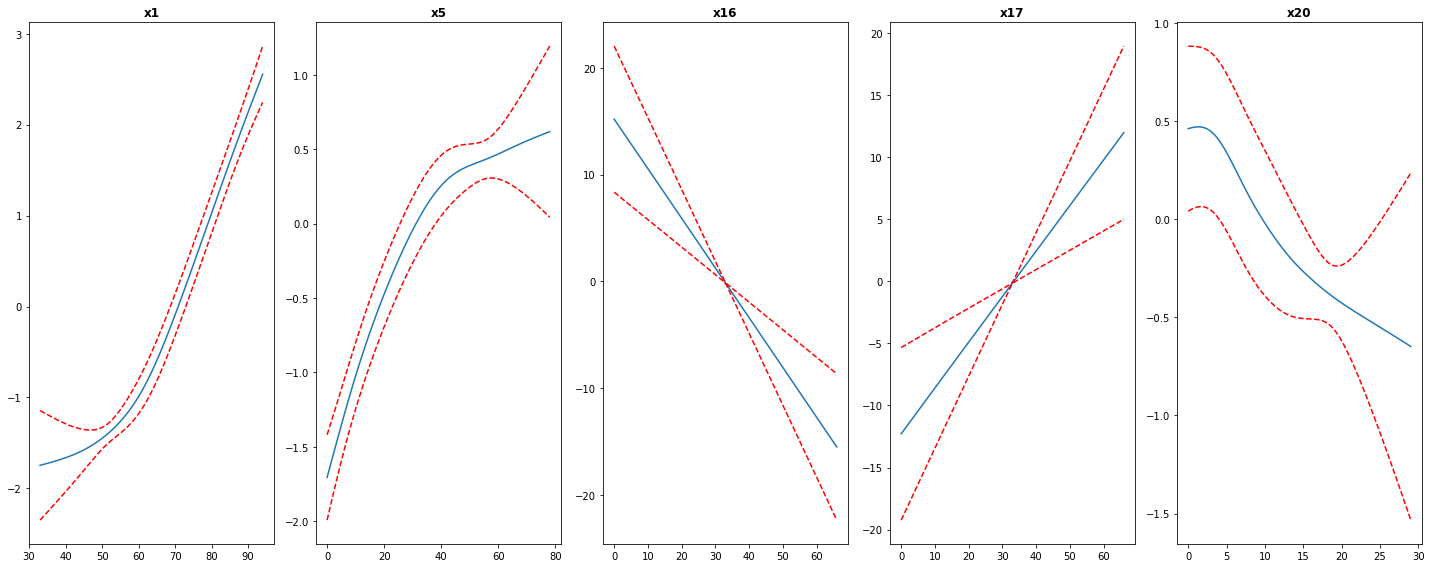

In [ ]:
spline_order = [3, 3, 3, 3, 3] 

gam_pspline = LogisticGAM(s(0, penalties='derivative', spline_order=spline_order[0])+
                          s(1, penalties='derivative', spline_order=spline_order[1])+
                          s(2, penalties='derivative', spline_order=spline_order[2])+
                          s(3, penalties='derivative', spline_order=spline_order[3])+
                          s(4, penalties='derivative', spline_order=spline_order[4]))
gam_pspline.gridsearch(x_train.to_numpy() ,y_train)

yhat_train_pspline = gam_pspline.predict(x_train)
print('Accuracy of penalized B-splines model on training dataset:',accuracy_score(y_train,yhat_train_pspline))

#Partial dependece plot
fig, axs = plt.subplots(1,5,figsize=(20,8))
names = ["x1", "x5", "x16", "x17", "x20"]
for i, ax in enumerate(axs.flatten()):
    XX = gam_pspline.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam_pspline.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam_pspline.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i],fontsize=12, fontweight="bold")
plt.tight_layout()

## Model performance

In [ ]:
y_test = df_test_imp[["RiskFlag_Good"]]
x_test = df_test_imp[["x1", "x5", "x16", "x17", "x20"]]
x_test_bin, y_test_bin = binning(df_test)

[INFO] creating woe binning ...


In [ ]:
#Performance on testing data
# (1) Binning
yhat_test_bin = gam_bin.predict(x_test_bin)
print('Accuracy of binning model:',accuracy_score(y_test,yhat_test_bin))

# (2) Piecewise-linear
yhat_test_pwlin = gam_pwlin.predict(x_test)
print('Accuracy of piecewise-linear model:',accuracy_score(y_test,yhat_test_pwlin))

# (2) Penalized B-splines
yhat_test_pspline = gam_pspline.predict(x_test)
print('Accuracy of penalized B-splines model:',accuracy_score(y_test,yhat_test_pspline))


Accuracy of binning model: 0.7194072657743786
Accuracy of piecewise-linear model: 0.7208413001912046
Accuracy of penalized B-splines model: 0.7208413001912046


Refer to the data description, x1, x5, x16, x17 and x20 are the "Consolidated version of risk markers", "Number Satisfactory Trades", "Number of Inq Last 6 Months", "Number of Inq Last 6 Months excl 7days. Excluding the last 7 days removes inquiries that are likely due to price comparision shopping." and "Number Revolving Trades with Balance" respectively.

Partial-dependence plots (PDPs) can be used to evaluate model explainability. The feature value has more contribution to the prediction if the response value is further away from 0. A model is explainable when the contribution of feature values (response value) is monotonic with its contribution. It provides a straight-forward interpretation when evaluating an individual observation.

First, it is noticed instantly that model (2) is not an explainable model. The PDPs of the piecewise-linear model (2) has a very wide confidence interval, hence the interpretation should be with caution. The trend of response value for features x1, x5 and x20 is not obvious due to the wide confidence intervals. Moreover, features x16 and x17 are both non-monotonic which is hard to be explained.

The binning model (1) provides a fairly explainable model. For features x1 and x5, the lowest bins do not provide great contribution but the proceeding ones have monotonically increasing response values. Feature x16 and x17 have a monotically decreasing and increasing response value respectively with the middle values having near-zero response value. These four features is rather explainable due to its monotonic or behaviour (when the value is high enough for features x1 and x5). However, feature x20 is not very explainable, where only the second and last bins have high response value while others do not.

The penalized B-splines model (3) is the most explainable model. The estimated response value of all five features are monotonic with feature values which provides high interpretability to the model. 

The accuracy of model (3) also supports the suggestion. The accuracy of the three models are very similar with piecewise-linear model and penalized B-splines model having the same higher accuracy. Given model (3) being more explainable and has higher accuracy, it is the suggested model to be used.